* Data cleaning
* word2vec
* Batch updates
* No MTL
* Regularization
* No weighting

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import itertools
from collections import defaultdict, OrderedDict
from random import shuffle
from tqdm import tqdm_notebook as tqdm, tnrange as trange
from sklearn.metrics import confusion_matrix

import sys
sys.path.insert(0, '..')
from evalResult import get_predicted, get_observed
plt.style.use('seaborn')

In [2]:
dataset = 'EN'

## Hyperparameters
Here for easy tuning.

In [3]:
lr = 0.01
batch_size = 64
n_epochs = 10

## Data

### Cleaning
Prepare words for cleaning. Specifically, find
1. ~~stopwords~~
1. punctuation
1. hashtags
1. @ mentions
1. numbers
1. URLs

In [4]:
re_punc = r'^[^a-zA-Z0-9]+$'
re_hash = r'^#'
re_at = r'^@'
re_num = r'\d'  # just remove all words with numbers
re_url = r'(^http:|\.com$)'

In [5]:
def clean_word(w):
    w = w.strip()
    if re.match(re_punc, w):
        return '#PUNC#'
    if re.match(re_hash, w):
        return '#HASH#'
    if re.match(re_at, w):
        return '#AT#'
    if re.match(re_num, w):
        return '#NUM#'
    if re.match(re_url, w):
        return '#URL#'
    return w.lower()

### I/O

In [6]:
def parse(train_filename):
    with open(train_filename, 'r') as f:
        lines = f.readlines()

    observations, states = defaultdict(int), defaultdict(int)
    for line in lines:
        data_split = line.strip().rsplit(' ', 1)
        if len(data_split) == 2:
            obs, state = data_split
            observations[clean_word(obs)] += 1
            states[state] += 1
    return observations, states

In [7]:
def read_file(filename, clean=True):
    with open(filename, 'r') as f:
        lines = f.readlines()
        
    sentence, label = [], []
    sentences, labels = [], []
    for line in lines:
        data_split = line.strip().rsplit(' ', 1)
        if len(data_split) == 2:
            word, state = data_split
            if clean:
                word = clean_word(word)
            sentence.append(word)
            label.append(state)
        else:
            sentences.append(sentence)
            labels.append(label)
            sentence = []
            label = []
    return sentences, labels

### Train data

In [8]:
train_filename = f'../data/{dataset}/train'

observations, states = parse(train_filename)

In [9]:
train_sentences, train_labels = read_file(train_filename)
train_sentences[0][:5], train_labels[0][:5]

(['rt', '#AT#', '#PUNC#', 'encore', '#PUNC#'], ['O', 'O', 'O', 'B-INTJ', 'O'])

### Validation data

In [10]:
val_filename = f'../data/{dataset}/dev.out'
val_sentences, val_labels = read_file(val_filename)
val_sentences[0][:5], val_labels[0][:5]

(['no', 'saints', 'r', '#PUNC#', 'buch'],
 ['B-NP', 'I-NP', 'I-NP', 'O', 'B-NP'])

In [11]:
out_filename = f'../data/{dataset}/dev.p5.out'

## Encoding

In [12]:
def one_hot_encode(n, depth):
    a = np.zeros([depth])
    a[n] = 1
    return a

### Encode words
Create a vocabulary out of words that appear more than `1` time(s) in training. Each word now maps to an _integer_. Other words will be treated as `#UNK#`.

In [13]:
w2v_W = np.load(f'weights/word2vec/{dataset}/W.npy')
w2v_U = np.load(f'weights/word2vec/{dataset}/U.npy')

def word2vec(sentence):
    """
    sentence: array of one-hot vectors [n_words, n_tokens]
    """
    weights = 0.5 * (w2v_W + w2v_U.T)  # [300, n_tokens]
    return sentence.dot(weights.T)  # [n_words, 300]

In [14]:
def tokenize(token_mapping, sentence):
    """
    Function to convert each word into its corresponding integer
    If word is not found, return the value for '#UNK'
    """
    return [token_mapping.get(w, token_mapping['#UNK#']) for w in sentence]



def prepare_inputs(token_mapping, sentences):
    """
    Converts a 2-D list of sentences (list of list of words)
    to one-hot encoded tokens of shape [n_sentences, n_words, len(token_mapping), 1].
    """
    tokens = [tokenize(token_mapping, sentence) for sentence in sentences] 
    
    depth = len(token_mapping)
    one_hot_tokens = []
    for sentence in tokens:
        one_hot_sentence = []
        for i, token in enumerate(sentence):
            if token != token_mapping['#UNK#']:
                one_hot_sentence.append(one_hot_encode(token, depth))
            else:
                if i <= 2:
                    context_tokens = sentence[:i] + sentence[i+1:i+3]
                else:
                    context_tokens = sentence[i-2:i] + sentence[i+1:i+3]
                context_one_hot = [one_hot_encode(token, depth) for token in context_tokens]
                context_mean = np.mean(np.asarray(context_one_hot), axis=0)
                one_hot_sentence.append(context_mean)
        one_hot_tokens.append(one_hot_sentence)
    
    one_hot_tokens = [np.asarray(ls) for ls in one_hot_tokens]
    vec_tokens = [word2vec(sentence) for sentence in tqdm(one_hot_tokens)]
    return vec_tokens

In [15]:
min_freq = 0

token_mapping = {}
for word in observations:
    if observations[word] > min_freq:  # appears more than once in training
        token_mapping[word] = len(token_mapping)
token_mapping['#UNK#'] = len(token_mapping)
len(token_mapping)

2504

In [16]:
X_train = prepare_inputs(token_mapping, train_sentences)
len(X_train), X_train[0].shape

(551, (25, 300))

### Encode labels
Perform a similar encoding for the states:
1. Map to integer
1. Convert from integer to one-hot-encoding

In [17]:
def prepare_labels(state_mapping, sequences):
    """
    Convert each state from str to its corresponding int value.
    Convert the int to a one-hot vector.
    """
    encoded_labels = [[state_mapping[state] for state in label] for label in sequences]
    
    depth = len(state_mapping)
    one_hot_labels = [[one_hot_encode(label, depth) for label in sequence] for sequence in encoded_labels]
    one_hot_labels = [np.asarray(ls) for ls in one_hot_labels]
    return one_hot_labels

In [18]:
state_mapping = {state: i for i, state in enumerate(states)}
state_mapping

{'O': 0,
 'B-INTJ': 1,
 'B-PP': 2,
 'B-NP': 3,
 'I-NP': 4,
 'B-VP': 5,
 'B-PRT': 6,
 'I-VP': 7,
 'B-ADJP': 8,
 'B-SBAR': 9,
 'B-ADVP': 10,
 'I-INTJ': 11,
 'B-CONJP': 12,
 'I-CONJP': 13,
 'I-ADVP': 14,
 'I-ADJP': 15,
 'I-SBAR': 16,
 'I-PP': 17}

In [19]:
y_train = prepare_labels(state_mapping, train_labels)
len(y_train), y_train[0].shape

(551, (25, 18))

### Validation
Perform a similar encoding for validation data, based on the states and tokens of the training data.

In [20]:
X_val = prepare_inputs(token_mapping, val_sentences)
y_val = prepare_labels(state_mapping, val_labels)

## MLP
$$
    x \in \mathbb{R}^{n \times 300} \\
    a_1, h_1, a_2, h_2 \in \mathbb{R}^{n \times 128} \\
$$
$$
    a_1 = xW + b \\
    h_1 = \text{ReLU}(a_1) \\
$$
$$
    a_2 = h_1V + c \\
    h_2 = \text{ReLU}(a_2) \\
$$
$$
    \hat{y} = \text{softmax}(h_2) \\
$$

In [21]:
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

### Initialization

In [22]:
np.random.seed(0)

n_hidden = 128  # number of hidden units
# layer 1
W = np.random.normal(0, 0.1, size=[300, n_hidden])
b = np.ones(shape=[1, n_hidden]) * 0.1
# layer 2
V = np.random.normal(0, 0.1, size=[n_hidden, n_hidden])
c = np.ones(shape=[1, n_hidden]) * 0.1
# output layer
U = np.random.normal(0, 0.1, size=[n_hidden, len(state_mapping)])
d = np.ones(shape=[1, len(state_mapping)]) * 0.1

In [23]:
model = (W, b, V, c, U, d)  # time for some unpacking magic

### Forward

In [24]:
def forward(W, b, V, c, U, d, x):
    """
    Compute the outputs at each time step.
    
    x - shape [n, 300]
    """
    a1 = x.dot(W) + b
    h1 = a1 * (a1 >= 0)
    
    a2 = h1.dot(V) + c
    h2 = a2 * (a2 >= 0)
    
    o = h2.dot(U) + d
    y_ = softmax(o)
    return y_

y_ = forward(*model, x=X_train[0])
y_.shape

(25, 18)

In [25]:
np.argmax(y_, axis=1).flatten()

array([ 5,  5,  7,  7,  7,  5, 10, 17, 14,  5, 17,  7, 17,  7,  5, 17, 17,
       14,  7, 17, 17,  7, 17, 17,  7])

### Evaluation

In [26]:
def predict(probs):
    states = list(state_mapping)
    indices = np.argmax(probs, axis=1)  # take argmax of the probs
    return [states[int(i)] for i in indices]  # map indices back to states

In [27]:
def write_predictions(*args, X):
    # get and store predictions
    result = []
    for i in trange(len(X_val), leave=False):
        y_pred = predict(forward(*args, x=X_val[i]))
        result.append(y_pred)
    # write predictions to file
    with open(out_filename, 'w') as f:
        for i in range(len(val_sentences)):
            for j in range(len(val_sentences[i])):
                word = val_sentences[i][j]
                pred = result[i][j]
                f.write(word + ' ' + pred + '\n')
            f.write('\n')

In [28]:
def compare(observed, predicted):
    correct_sentiment = 0
    correct_entity = 0

    total_observed = 0.0
    total_predicted = 0.0

    #For each Instance Index example (example = 0,1,2,3.....)
    for example in observed:
        observed_instance = observed[example]
        predicted_instance = predicted[example]

        #Count number of entities in gold data
        total_observed += len(observed_instance)
        #Count number of entities in prediction data
        total_predicted += len(predicted_instance)

        #For each entity in prediction
        for span in predicted_instance:
            span_begin = span[1]
            span_length = len(span) - 1
            span_ne = (span_begin, span_length)
            span_sent = span[0]

            #For each entity in gold data
            for observed_span in observed_instance:
                begin = observed_span[1]
                length = len(observed_span) - 1
                ne = (begin, length)
                sent = observed_span[0]

                #Entity matched
                if span_ne == ne:
                    correct_entity += 1
                    #Entity & Sentiment both are matched
                    if span_sent == sent:
                        correct_sentiment += 1

    prec = correct_entity/total_predicted if total_predicted != 0 else 0
    rec = correct_entity/total_observed if total_observed != 0 else 0
    if abs(prec + rec) < 1e-6:
        f = 0
    else:
        f = 2 * prec * rec / (prec + rec)
    entity_scores = (prec, rec, f)

    prec = correct_sentiment/total_predicted if total_predicted != 0 else 0
    rec = correct_sentiment/total_observed if total_observed != 0 else 0
    if abs(prec + rec) < 1e-6:
        f = 0
    else:
        f = 2 * prec * rec / (prec + rec)
    type_scores = (prec, rec, f)
    return entity_scores, type_scores

def get_scores(*args, X):
    write_predictions(*args, X=X_val)
    observed = get_observed(open(val_filename, 'r'))
    predicted = get_predicted(open(out_filename, 'r'))
    return compare(observed, predicted)

get_scores(*model, X=X_val)

((0.321, 0.4002493765586035, 0.35627081021087686),
 (0.069, 0.08603491271820449, 0.07658157602663708))

### Backward
`<insert derived backpropagation equations here>`

#### Weighting

In [29]:
from functools import reduce
from operator import add
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(class_weight='balanced',
                               classes=list(states),
                               y=reduce(add, ([k]*v for k, v in states.items())))
weights

array([2.70931589e-01, 2.30977086e+00, 8.29065798e-01, 2.14454881e-01,
       3.11770542e-01, 4.47333166e-01, 6.98366013e+00, 9.77942522e-01,
       3.73340321e+00, 8.36071987e+00, 1.53785262e+00, 6.74558081e+00,
       2.96805556e+02, 2.96805556e+02, 1.16394336e+01, 9.73132969e+00,
       1.48402778e+02, 9.89351852e+01])

#### Gradients

In [30]:
def backward(W, b, V, c, U, d, x, y):
    assert len(x) == len(y), [len(x), len(y)]

    # feedforward
    a1 = x.dot(W) + b
    h1 = a1 * (a1 >= 0)
    
    a2 = h1.dot(V) + c
    h2 = a2 * (a2 >= 0)
    
    o = h2.dot(U) + d
    y_ = softmax(o)

    # backprop
    do = y_ - y
    
    dd = np.mean(do, axis=0, keepdims=True)
    dU = h2.T.dot(do)
    
    dh2 = do.dot(U.T)
    da2 = dh2 * (a2 >= 0)
    
    dc = np.mean(da2, axis=0, keepdims=True)
    dV = h1.T.dot(da2)
    
    dh1 = da2.dot(V.T)
    da1 = dh1 * (a1 >= 0)
    
    db = np.mean(da1, axis=0, keepdims=True)
    dW = x.T.dot(da1)
    
    assert dW.shape == W.shape
    assert db.shape == b.shape
    assert dV.shape == V.shape
    assert dc.shape == c.shape
    assert dU.shape == U.shape
    assert dd.shape == d.shape

    grad = (dW, db, dV, dc, dU, dd)
    
    # compute loss
    xent = -np.log(y_ + 1e-8) * y
    loss = np.mean(np.sum(xent, axis=1))
    return loss, grad
        
for i in trange(len(X_train)):
    backward(*model, x=X_train[i], y=y_train[i])

##### Training

In [31]:
%%script true
# overfitting check
losses = []
n_iters = 1000
for i in trange(n_iters):
    x, y = X_train[0], y_train[0]
    loss, grad = backward(*model, x=x, y=y)
    
    losses.append(loss)
    for error, weight in zip(grad, model):
        weight -= lr * error

plt.plot(np.arange(n_iters), losses);

y_pred = predict(forward(*model, x=X_train[0]))
y_true = train_labels[0]
np.mean(np.array(y_pred) == np.array(y_true))

In [32]:
X_flat, y_flat = [], []

for sentence in X_train:
    X_flat.extend(sentence)
X_flat = np.asarray(X_flat)

for sentence in y_train:
    y_flat.extend(sentence)
y_flat = np.asarray(y_flat)

X_flat.shape, y_flat.shape

((10685, 300), (10685, 18))

In [33]:
checkpoints = []  # store model weights after every epoch
losses = []  # training loss
scores = []  # f1-score
cum_grad = [np.zeros_like(weight) for weight in model]

n_iters = len(X_flat) // batch_size
for i in trange(n_epochs):
    for j in trange(n_iters, leave=False):
        idx = np.random.choice(np.arange(len(X_flat)), size=batch_size)
        x, y = X_flat[idx], y_flat[idx]
        loss, grad = backward(*model, x=x, y=y)

        # gradient accumulation
        for cum_weight, weight_update in zip(cum_grad, grad):
            cum_weight += np.square(weight_update)
        # gradient update
        for weight, cum_weight, weight_update in zip(model, cum_grad, grad):
            weight -= (lr / (np.sqrt(cum_weight) + 1e-7)) * weight_update

        losses.append(loss)
    scores.append(get_scores(*model, X=X_val))
    checkpoints.append(tuple(weights.copy() for weights in model))

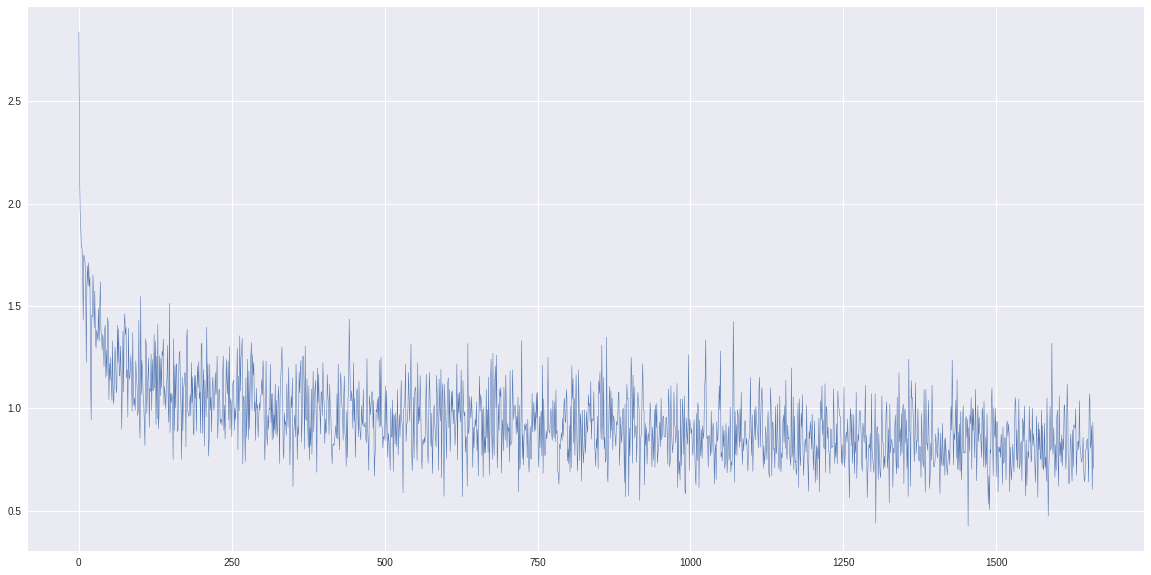

In [34]:
plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(losses)), losses, linewidth=0.5);  # overall training loss

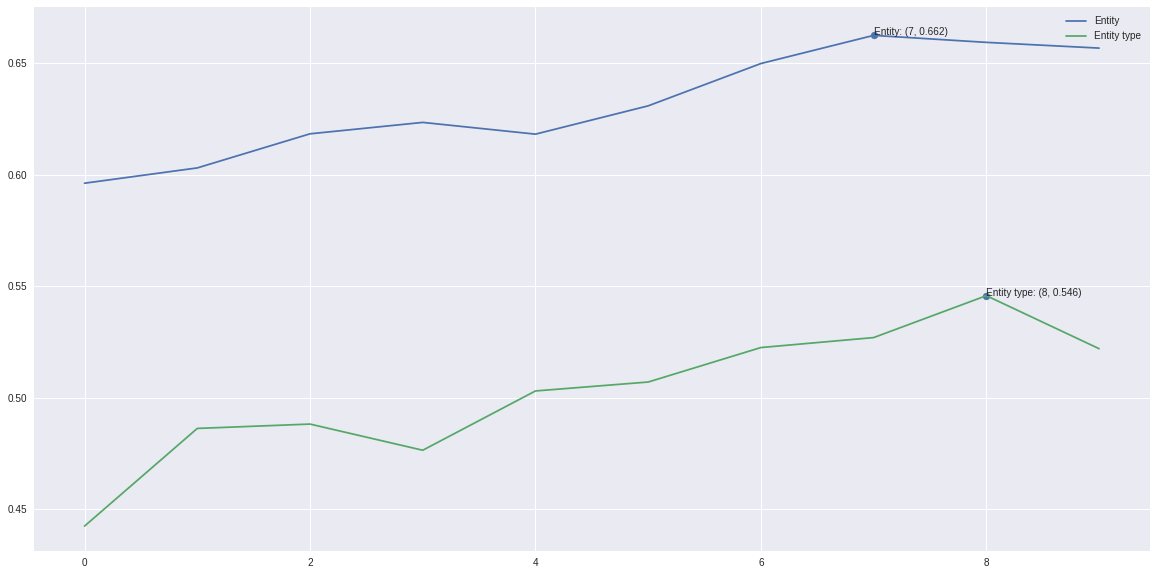

In [35]:
f_entity = [tup[0][-1] for tup in scores]
f_type = [tup[1][-1] for tup in scores]

x = [np.argmax(f_entity), np.argmax(f_type)]
y = [np.max(f_entity), np.max(f_type)]


plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(f_entity)), f_entity, label='Entity')
plt.plot(np.arange(len(f_type)), f_type, label='Entity type')

plt.scatter(x, y)
plt.annotate(f'Entity: ({x[0]}, {np.round(y[0], 3)})', (x[0], y[0]))
plt.annotate(f'Entity type: ({x[1]}, {np.round(y[1], 3)})', (x[1], y[1]))

plt.legend();

## Prediction

In [36]:
y_pred = predict(forward(*model, x=X_val[0]))
y_true = val_labels[0]
for _pred, _true in zip(y_pred, y_true):
    print(_pred, _true, sep='\t')

B-NP	B-NP
B-NP	I-NP
B-VP	I-NP
O	O
I-NP	B-NP
B-VP	B-VP
B-VP	I-VP
B-ADVP	B-ADVP
O	O
I-VP	B-VP
I-NP	B-PP
I-NP	B-NP
B-PP	B-PP
B-NP	B-NP
O	O


Check for class imbalance.

In [37]:
all_pred, all_true = [], []
for i in trange(len(X_val)):
    y_pred = np.argmax(softmax(forward(*model, x=X_val[i])), axis=1).flatten()
    y_true = np.argmax(y_val[i], axis=1).flatten()
    all_pred.extend(y_pred)
    all_true.extend(y_true)
all_pred = np.asarray(all_pred)
all_true = np.asarray(all_true)

Confusion matrix, without normalization


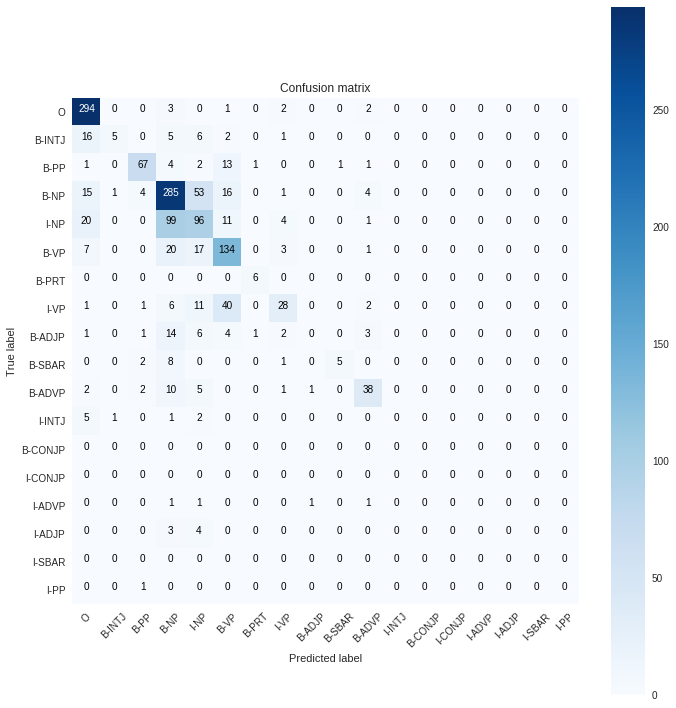

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    
cm = confusion_matrix(all_true, all_pred, labels=np.arange(len(state_mapping)))
classes = list(state_mapping)

plt.figure(figsize=(10, 10))
plt.grid(False)
plot_confusion_matrix(cm, classes=classes)

## Save model

In [39]:
%%script true
def save_model(U, W, b, V, c, path, name):
    if not os.path.isdir(path):
        os.makedirs(path)
    np.save(f'{path}/{name}_U', U)
    np.save(f'{path}/{name}_W', W)
    np.save(f'{path}/{name}_b', b)
    np.save(f'{path}/{name}_V', V)
    np.save(f'{path}/{name}_c', c)
    return True

save_model(*model, path='weights/EN', name=f'epochs{n_epochs}_lr{lr}')